# More Performance Tests

In [1]:
push!(LOAD_PATH, "..")
using ASE, TestAtoms, MatSciPy, AtomsInterface
using TightBinding
import TightBinding.NRLTB
import ProfileView, Base.Profile

In [6]:
at = bulk("Al"; cubic=true)
at = repeat(at, (3, 3, 3))
@show length(at)
set_pbc!(at, [false, false, true])
X = positions(at)
tbm = NRLTB.NRLTBModel(elem = NRLTB.Al_spd)
# tbm = TightBinding.ToyTB.ToyTBModel()
tbm.nkpoints = (0,0,8)
# TestAtoms.test_potentialenergy(tbm, at)
set_positions!(at, X+0.1*rand(size(X)))
k = rand(3);

# @time H, M = TightBinding.hamiltonian(at, tbm, k)
# @time H, M = TightBinding.hamiltonian(at, tbm, k)
# @time H, M = TightBinding.hamiltonian(at, tbm, k)

@time H, M = TightBinding.forces(at, tbm)
@time H, M = TightBinding.forces(at, tbm)

@time H, M = TightBinding.forces_(at, tbm)
@time H, M = TightBinding.forces_(at, tbm)



# @time H, M = TightBinding.forces_(at, tbm)
# @time H, M = TightBinding.forces_(at, tbm)
# @time H, M = TightBinding.forces_(at, tbm)


;

length(at) = 108
ctr = 9447840
  8.599494 seconds (13.20 M allocations: 4.424 GB, 9.20% gc time)
ctr = 9447840
  3.016584 seconds (9.80 M allocations: 2.640 GB, 9.83% gc time)
ctr = 34885080
179.859661 seconds (353.20 M allocations: 5.778 GB, 0.33% gc time)
ctr = 34885080
173.602939 seconds (353.20 M allocations: 5.778 GB, 0.32% gc time)


In [3]:
@code_warntype TightBinding.forces_(at, tbm)

Variables:
  atm::ASE.ASEAtoms
  tbm::TightBinding.TBModel{TightBinding.NRLTB.NRLos,TightBinding.NRLTB.NRLhop,TightBinding.NRLTB.NRLoverlap,Potentials.ZeroPairPotential}
  frc::ARRAY{T,N}
  nlist::MatSciPy.NeighbourList
  X::Array{Float64,2}
  K::Array{Float64,2}
  weight::Array{Float64,1}
  #s41::Int64
  df::Array{Float64,2}
  dfe::Array{Float64,2}
  dH_nn::Array{Float64,4}
  dH_nm::Array{Float64,3}
  dM_nm::Array{Float64,3}
  #s39::MatSciPy.AtomIteratorState
  n::Int64
  neigs::Array{Int32,1}
  r::Array{Float64,1}
  R::SubArray{Float64,2,Array{Float64,2},Tuple{Colon,UnitRange{Int64}},2}
  _::SubArray{Int32,2,Array{Int32,2},Tuple{Colon,UnitRange{Int64}},2}
  #s38::Int64
  In::Array{Int64,1}
  #s37::Int64
  i_n::Int64
  m::Int32
  Im::Array{Int64,1}
  #s36::Int64
  k::Array{Float64,1}
  kR::Float64
  eikr::Complex{Float64}
  C::Array{Complex{Float64},2}
  #87#iK::Int64
  #s32::Int64
  a::Int64
  #s35::Int64
  b::Int64
  Ima::Int64
  Ina::Int64
  Inb::Int64
  t3::Complex{Float64}
  t2::

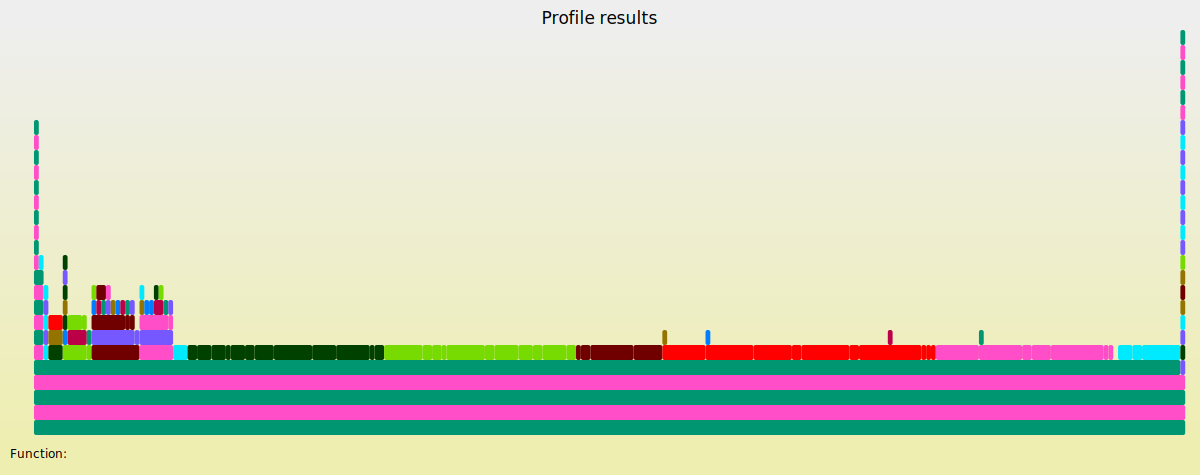

In [6]:
Profile.clear()
@profile TightBinding.forces_(at, tbm)
ProfileView.view()

In [39]:
@code_warntype hamiltonian(at, tbm, rand(3))

Variables:
  atm::ASE.ASEAtoms
  tbm::TightBinding.TBModel{TightBinding.NRLTB.NRLos,TightBinding.NRLTB.NRLhop,TightBinding.NRLTB.NRLoverlap,Potentials.ZeroPairPotential}
  k::Array{Float64,1}
  nlist::MatSciPy.NeighbourList
  nnz_est::Int64
  H::SparseTools.SparseTriplet{Complex{Float64}}
  M::SparseTools.SparseTriplet{Complex{Float64}}
  X::Array{Float64,2}
  #s41::MatSciPy.AtomIteratorState
  n::Int64
  neigs::Array{Int32,1}
  r::Array{Float64,1}
  R::Array{Float64,2}
  #s40::Int64
  In::Array{Int64,1}
  exp_i_kR::Array{Complex{Float64},2}
  H_nn::Array{Float64,2}
  M_nn::Array{Float64,2}
  #s39::Int64
  m::Int64
  Im::Array{Int64,1}
  H_nm::Array{Float64,2}
  M_nm::Array{Float64,2}
  ##xs#11849::Tuple{}
  ######dims#11457#11460#11850::Tuple{Int64}
  ######dims#11458#11461#11851::Tuple{Int64}
  ######dims#11459#11462#11852::Tuple{Int64}
  ######dims#11457#11460#11853::Tuple{Int64}
  ######dims#11458#11461#11854::Tuple{Int64}
  ######dims#11459#11462#11855::Tuple{Int64}
  ######xs#763

In [1]:
push!(LOAD_PATH, "..")
using ASE, TestAtoms, MatSciPy, AtomsInterface
using TightBinding
import TightBinding.NRLTB
import ProfileView, Base.Profile

In [4]:
# copied the hamiltonian from TightBinding module for testing
#

function hamiltonian_fast(atm::ASEAtoms, tbm::TBModel, k, It, Jt, Ht, Mt, nlist)
    # create a neighbourlist
    
    # setup a huge sparse matrix, we need a rough estimate for the number of
    idx = 0
    norbsq = tbm.norbitals^2
    
    im_kt_cell = k' * cell(atm)
    
    H_nm = zeros(tbm.norbitals, tbm.norbitals)
    M_nm = zeros(tbm.norbitals, tbm.norbitals)
    temp = zeros(10)

    X = positions(atm)::Matrix{Float64}
    # loop through all atoms
    for (n, neigs, r, R, S) in Sites(nlist)
        # index-block for atom index n
        In = TightBinding.indexblock(n, tbm)
         exp_i_kR = exp(im * (k' * (R - (X[:,neigs] .- X[:,n]))))
        # the following is an equivalent definition. Why is it slower?
#         exp_i_kR = exp(im_kt_cell * S)
        # loop through the neighbours of the current atom
        for m = 1:length(neigs)
            # get the block of indices for atom m
            Im = TightBinding.indexblock(neigs[m], tbm)
            # compute hamiltonian block
#             H_nm =  tbm.hop(r[m], R[:, m])
            H_nm =  NRLTB.evaluate!(tbm.hop, r[m], R[:, m], H_nm, temp)
            # compute overlap block
#             M_nm = tbm.overlap(r[m], R[:,m])
            M_nm = NRLTB.evaluate!(tbm.overlap, r[m], R[:,m], M_nm, temp)
            # add new indices into the sparse matrix
            @inbounds for i = 1:tbm.norbitals, j = 1:tbm.norbitals
                idx += 1
                It[idx] = In[i]
                Jt[idx] = Im[j]
                Ht[idx] = H_nm[i,j]*exp_i_kR[m]
                Mt[idx] = M_nm[i,j]*exp_i_kR[m]
            end
        end
        # now compute the on-site terms
        H_nn = tbm.onsite(r, R)   # OLD: get_os!(R, tbm, H_nm)
        # overlap diagonal block
        M_nn = tbm.overlap(0.0)
        # add into sparse matrix
        for i = 1:tbm.norbitals, j = 1:tbm.norbitals
            idx += 1
            It[idx] = In[i]
            Jt[idx] = In[j]
            Ht[idx] = H_nn[i,j]
            Mt[idx] = M_nn[i,j]
        end
    end
    
    # convert M, H and return
     return sparse(It, Jt, Ht), sparse(It, Jt, Mt)
end



hamiltonian_fast (generic function with 1 method)

In [19]:
at = bulk("Al"; cubic=true)
at = repeat(at, (5, 5, 2))
@show length(at)
set_pbc!(at, [false, false, true])
X = positions(at)
tbm = NRLTB.NRLTBModel(elem = NRLTB.Al_spd)
# tbm = TightBinding.ToyTB.ToyTBModel()
tbm.nkpoints = (0,0,1)
# TestAtoms.test_potentialenergy(tbm, at)
set_positions!(at, X+0.1*rand(size(X)))
k = rand(3);

nlist = NeighbourList(TightBinding.cutoff(tbm), at)
nnz_est = (length(nlist) * tbm.norbitals^2 + length(at) * tbm.norbitals^2)
#     nnz_est = 2 * length(nlist.i) * tbm.norbitals^2
It = zeros(Int32, nnz_est)
Jt = zeros(Int32, nnz_est)
Ht = zeros(Complex{Float64}, nnz_est)
Mt = zeros(Complex{Float64}, nnz_est)

@time hamiltonian_fast(at, tbm, k, It, Jt, Ht, Mt, nlist)
@time hamiltonian_fast(at, tbm, k, It, Jt, Ht, Mt, nlist)
@time H, M = hamiltonian_fast(at, tbm, k, It, Jt, Ht, Mt, nlist)
@time eigfact(full(H), full(M))

;

length(at) = 200
  0.695489 seconds (2.08 M allocations: 274.811 MB, 18.35% gc time)
  0.609938 seconds (2.08 M allocations: 274.811 MB, 11.69% gc time)
  0.640712 seconds (2.08 M allocations: 274.811 MB, 13.49% gc time)
  4.789149 seconds (38 allocations: 346.277 MB, 2.72% gc time)


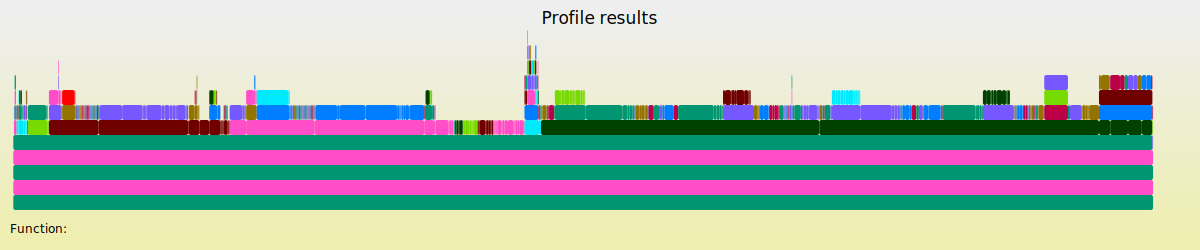

In [6]:
Profile.clear()
@profile hamiltonian_fast(at, tbm, k, It, Jt, Ht, Mt, nlist)
ProfileView.view()

In [7]:
# @code_warntype hamiltonian_fast(at, tbm, k)

In [1]:
push!(LOAD_PATH, "..")
using ASE, TestAtoms, MatSciPy, AtomsInterface
using TightBinding, Potentials
import TightBinding.NRLTB
import ProfileView, Base.Profile

In [2]:
# copied the hamiltonian from TightBinding module for testing
#

function hamiltonian_faster(atm::ASEAtoms, tbm::TBModel, k::Vector{Float64})
    # X, nlist, and the allocation of the I,J,H,M arrays 
    # can be moved outside the k-dependent method
    #    
    Natm = length(atm)::Int
    X = positions(atm)::Matrix{Float64}
    nlist = NeighbourList(TightBinding.cutoff(tbm), atm)
    # setup a huge sparse matrix, we need a rough estimate for the number of nonzeros
    nnz_est = (length(nlist.i) * tbm.norbitals^2 + Natm * tbm.norbitals^2)::Int
    It = zeros(Int32, nnz_est)
    Jt = zeros(Int32, nnz_est)
    Ht = zeros(Complex{Float64}, nnz_est)
    Mt = zeros(Complex{Float64}, nnz_est)
    idx = 0
    norbsq = tbm.norbitals^2
    
    # need to tell Julia that this is a Float64, since ASE is type-unstable
    im_kt_cell = (im * cell(atm)' * k)::Vector{Complex{Float64}}   
    im_k = im * k
    
    H_ij = zeros(tbm.norbitals, tbm.norbitals)
    M_ij = zeros(tbm.norbitals, tbm.norbitals)
    
    blocks = zeros(Int32, tbm.norbitals, Natm)
    for n = 1:Natm
        blocks[:, n] = TightBinding.indexblock(n, tbm)
    end

    for (i, j, r, R, S) in Bonds(nlist)
        exp_i_kR = exp(dot(im_kt_cell, S)) # exp(dot(im_k, R - X[:,j] + X[:,i]))
        # Ii = TightBinding.indexblock(i, tbm)
        # Ij = TightBinding.indexblock(j, tbm)
        # compute hamiltonian block
        H_ij = ip_evaluate(tbm.hop, r, R, H_ij)    # tbm.hop(r, R)
        # compute overlap block
        M_ij = ip_evaluate(tbm.overlap, r, R, M_ij) # tbm.overlap(r, R)
        # add new indices into the sparse matrix
        @inbounds for a = 1:tbm.norbitals, b = 1:tbm.norbitals
            idx += 1
            It[idx] = blocks[a,i]
            Jt[idx] = blocks[b,j]
            Ht[idx] = H_ij[a,b] * exp_i_kR
            Mt[idx] = M_ij[a,b] * exp_i_kR
        end
    end
    
    # now compute the on-site terms
    for (n, _, r, R, _) in Sites(nlist)
        # In = TightBinding.indexblock(n, tbm)
        H_nn = tbm.onsite(r, R)
        # overlap diagonal block
        M_nn = tbm.overlap(0.0)
        # add into sparse matrix
        @inbounds for a = 1:tbm.norbitals, b = 1:tbm.norbitals
            idx += 1
            It[idx] = blocks[a,n] # In[i]
            Jt[idx] = blocks[b,n] # In[j]
            Ht[idx] = H_nn[a,b]
            Mt[idx] = M_nn[a,b]
        end
    end
    
    # convert M, H and return
    return sparse(It, Jt, Ht), sparse(It, Jt, Mt)
end




hamiltonian_faster (generic function with 1 method)

In [47]:
at = bulk("Al"; cubic=true)
at = repeat(at, (5, 5, 2))
@show length(at)
set_pbc!(at, [false, false, true])
X = positions(at)
tbm = NRLTB.NRLTBModel(elem = NRLTB.Al_spd)
# tbm = TightBinding.ToyTB.ToyTBModel()
tbm.nkpoints = (0,0,1)
# TestAtoms.test_potentialenergy(tbm, at)
set_positions!(at, X+0.1*rand(size(X)))
k = rand(3);

@time H, M = hamiltonian_faster(at, tbm, k)
@time H, M = hamiltonian_fast(at, tbm, k)

@time H, M = hamiltonian_faster(at, tbm, k)
@time H, M = hamiltonian_fast(at, tbm, k)

@time H, M = hamiltonian_faster(at, tbm, k)
@time H, M = hamiltonian_fast(at, tbm, k)

;

length(at) = 200
  1.045674 seconds (2.37 M allocations: 780.035 MB, 25.10% gc time)
  0.923108 seconds (1.70 M allocations: 777.924 MB, 20.17% gc time)
  0.878652 seconds (2.30 M allocations: 776.930 MB, 19.15% gc time)
  0.882902 seconds (1.70 M allocations: 777.924 MB, 15.72% gc time)
  0.937225 seconds (2.30 M allocations: 776.930 MB, 17.34% gc time)
  0.864841 seconds (1.70 M allocations: 777.924 MB, 18.07% gc time)


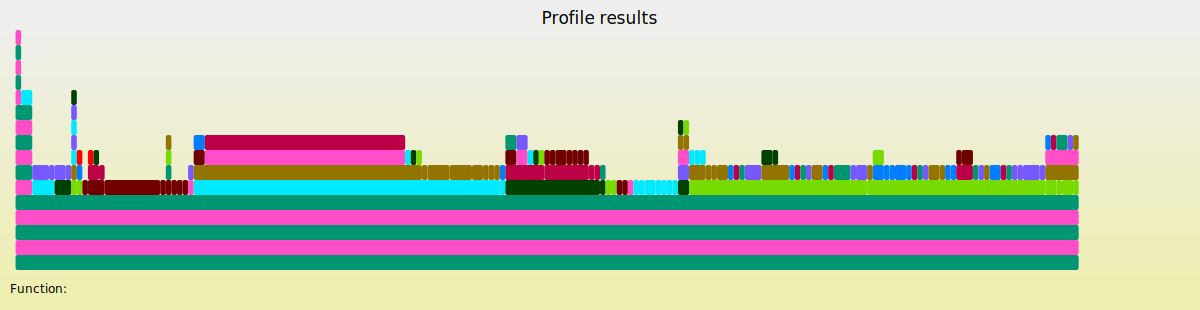

In [27]:
Profile.clear()
@profile hamiltonian_faster(at, tbm, k)
ProfileView.view()

In [9]:
H, M = TightBinding.hamiltonian(at, tbm, k)
Hf, Mf = hamiltonian_fast(at, tbm, k, It, Jt, Ht, Mt, nlist)
@show vecnorm(H-Hf), vecnorm(M-Mf)



(vecnorm(H - Hf),vecnorm(M - Mf)) = (0.0,0.0)

(0.0,0.0)

In [18]:
Eigen = eigfact(full(Hf), full(Mf))


Base.LinAlg.GeneralizedEigen{Complex{Float64},Float64,Array{Complex{Float64},2},Array{Float64,1}}([-0.442944,-0.433753,-0.433503,-0.421784,-0.413056,-0.412063,-0.398833,-0.398372,-0.379179,-0.379134  …  2.16665,2.16756,2.16847,2.16885,2.17485,2.1765,2.17745,2.17848,2.18018,2.18099],1800x1800 Array{Complex{Float64},2}:
           -0.00164807-0.0012275im    …           -0.00346235-0.0016866im  
            0.00171571+0.00128111im                0.00377982+0.00250285im 
            0.00171823+0.0012881im                  0.0055074+0.00198481im 
           0.000392714-0.000537308im             -0.000170218+0.000410884im
          -0.000285373-0.000212276im              -0.00822909-0.00386052im 
            -9.4155e-5+0.000123852im  …           0.000423582+0.000140662im
           -8.92404e-5+0.00011884im       6.11474e-5-2.56973e-5im          
   -1.33901e-6+1.4894e-6im                         0.00170081-0.000681952im
           0.000142841+0.000102463im               0.00518915+0.00256395

In [16]:
?eigfact

search: 

```rst
..  eigfact(A,[irange,][vl,][vu,][permute=true,][scale=true]) -> Eigen

Computes the eigenvalue decomposition of ``A``, returning an ``Eigen``
factorization object ``F`` which contains the eigenvalues in ``F[:values]``
and the eigenvectors in the columns of the matrix ``F[:vectors]``.
(The ``k``\ th eigenvector can be obtained from the slice ``F[:vectors][:, k]``.)

The following functions are available for ``Eigen`` objects: ``inv``,
``det``.

If ``A`` is :class:`Symmetric`, :class:`Hermitian` or :class:`SymTridiagonal`,
it is possible to calculate only a subset of the eigenvalues by specifying
either a :class:`UnitRange` ``irange`` covering indices of the sorted
eigenvalues or a pair ``vl`` and ``vu`` for the lower and upper boundaries
of the eigenvalues.

For general nonsymmetric matrices it is possible to specify how the matrix
is balanced before the eigenvector calculation. The option ``permute=true``
permutes the matrix to become closer to upper triangular, and ``scale=true``
scales the matrix by its diagonal elements to make rows and columns more
equal in norm. The default is ``true`` for both options.
```

```rst
..  eigfact(A, B) -> GeneralizedEigen

Computes the generalized eigenvalue decomposition of ``A`` and ``B``,
returning a ``GeneralizedEigen`` factorization object ``F`` which contains
the generalized eigenvalues in ``F[:values]`` and the generalized
eigenvectors in the columns of the matrix ``F[:vectors]``. (The ``k``\ th
generalized eigenvector can be obtained from the slice ``F[:vectors][:,
k]``.)
```


eigfact eigfact! set_bigfloat_precision get_bigfloat_precision



In [ ]:
##### LAST WORKING VERSION

# copied the hamiltonian from TightBinding module for testing
#

function hamiltonian_fast(atm::ASEAtoms, tbm::TBModel, k, It, Jt, Ht, Mt, nlist)
    # create a neighbourlist
    
    # setup a huge sparse matrix, we need a rough estimate for the number of
    idx = 0
    norbsq = tbm.norbitals^2
    
#     im_kt_cell = k' * cell(atm)
    
    H_nm = zeros(tbm.norbitals, tbm.norbitals)
    M_nm = zeros(tbm.norbitals, tbm.norbitals)

        
    X = positions(atm)::Matrix{Float64}
    # loop through all atoms
    for (n, neigs, r, R, S) in Sites(nlist)
        # index-block for atom index n
        In = TightBinding.indexblock(n, tbm)
        exp_i_kR = exp(im * (k' * (R - (X[:,neigs] .- X[:,n]))))
        # the following is an equivalent definition. Why is it slower?
#         exp_i_kR = exp(im_kt_cell * S)
        # loop through the neighbours of the current atom
        for m = 1:length(neigs)
            # get the block of indices for atom m
            Im = TightBinding.indexblock(neigs[m], tbm)
            # compute hamiltonian block
#             H_nm =  tbm.hop(r[m], R[:, m])
            H_nm =  NRLTB.evaluate!(tbm.hop, r[m], R[:, m], H_nm)
            # compute overlap block
#             M_nm = tbm.overlap(r[m], R[:,m])
            M_nm = NRLTB.evaluate!(tbm.overlap, r[m], R[:,m], M_nm)
            # add new indices into the sparse matrix
            @inbounds for i = 1:tbm.norbitals, j = 1:tbm.norbitals
                idx += 1
                It[idx] = In[i]
                Jt[idx] = Im[j]
                Ht[idx] = H_nm[i,j]*exp_i_kR[m]
                Mt[idx] = M_nm[i,j]*exp_i_kR[m]
            end
        end
        # now compute the on-site terms
        H_nn = tbm.onsite(r, R)   # OLD: get_os!(R, tbm, H_nm)
        # overlap diagonal block
        M_nn = tbm.overlap(0.0)
        # add into sparse matrix
        for i = 1:tbm.norbitals, j = 1:tbm.norbitals
            idx += 1
            It[idx] = In[i]
            Jt[idx] = In[j]
            Ht[idx] = H_nn[i,j]
            Mt[idx] = M_nn[i,j]
        end
    end
    
    # convert M, H and return
    return sparse(It, Jt, Ht), sparse(It, Jt, Mt)
end


